<a href="https://colab.research.google.com/github/suarim/samsung_prism_camera_motion_estimation/blob/main/copy_of_posenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
def pose_exp_net(tgt_img, src_imgs, do_exp=True):
    inputs = tf.concat([tgt_img, src_imgs], axis=3)
    inputs = tf.cast(inputs, dtype=tf.float32)

    print(inputs.dtype)



    x = layers.Conv2D(16, (7, 7), strides=2, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)


    x = layers.Conv2D(256, (3, 3), strides=2, activation='relu', padding='same', name='pose/cnv6')(x)
    x = layers.Conv2D(256, (3, 3), strides=2, activation='relu', padding='same', name='pose/cnv7')(x)
    pose_pred = layers.Conv2D(6 * num_source, (1, 1), name='pose/pred')(x)

    # Reshape idk y
    pose_avg = tf.reduce_mean(pose_pred, [1, 2])
    pose_final = 0.01 * tf.reshape(pose_avg, [-1, num_source, 6])

    if do_exp:

        upcnv5 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same', name='exp/upcnv5')(x)
        mask4 = layers.Conv2D(num_source * 2, (3, 3), strides=1, padding='same', name='exp/mask4')(upcnv5)

        upcnv4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same', name='exp/upcnv4')(upcnv5)
        mask3 = layers.Conv2D(num_source * 2, (3, 3), strides=1, padding='same', name='exp/mask3')(upcnv4)

        upcnv3 = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same', name='exp/upcnv3')(upcnv4)
        mask2 = layers.Conv2D(num_source * 2, (3, 3), strides=1, padding='same', name='exp/mask2')(upcnv3)

        upcnv2 = layers.Conv2DTranspose(32, (5, 5), strides=2, activation='relu', padding='same', name='exp/upcnv2')(upcnv3)
        mask1 = layers.Conv2D(num_source * 2, (5, 5), strides=1, padding='same', name='exp/mask1')(upcnv2)

        return pose_final, [mask1, mask2, mask3, mask4]

    return pose_final

In [ ]:
im = pose_exp_net(d , s , do_exp=False)

<dtype: 'float32'>


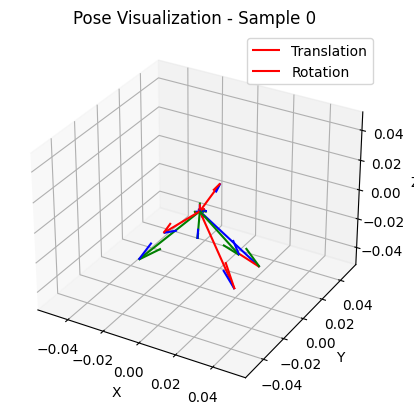

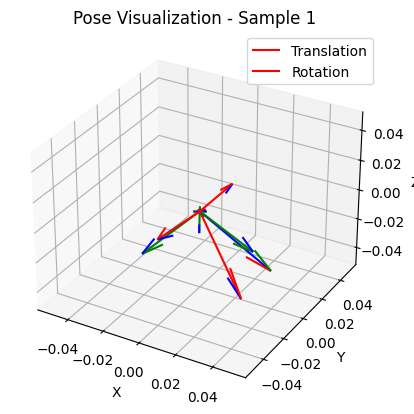

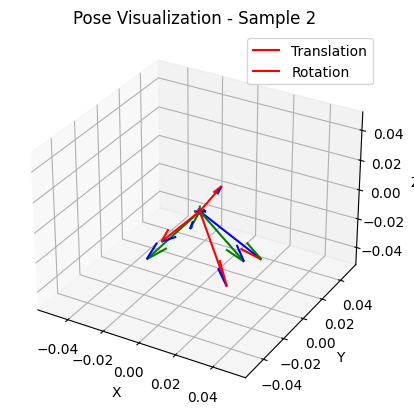

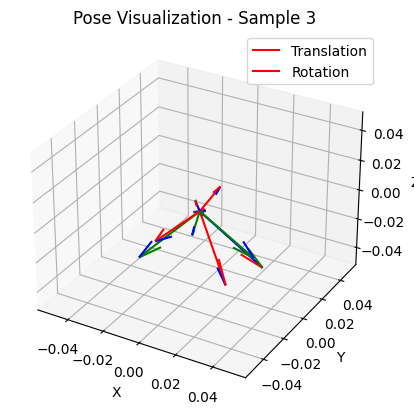

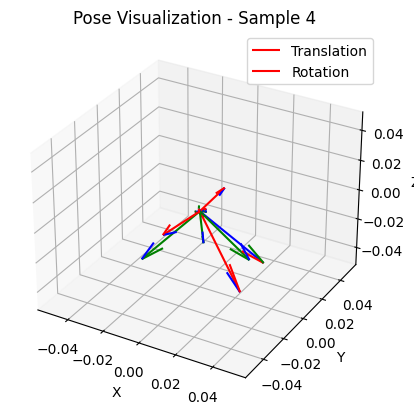

In [ ]:
import matplotlib.pyplot as plt


def plot_poses(pose_final):
    # Assuming pose_final has shape (batch_size, num_source, 6)
    num_poses = pose_final.shape[0]

    for i in range(num_poses):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Extracting translation and rotation components
        translation = pose_final[i, :, :3]
        rotation = pose_final[i, :, 3:]

        # Plotting translation vectors
        ax.quiver(0, 0, 0, translation[:, 0], translation[:, 1], translation[:, 2],
                  color=['r', 'g', 'b'], label='Translation')

        # Plotting rotation vectors (scaled for visualization)
        rotation_scale = 0.1
        rotated_vectors = rotation_scale * rotation
        ax.quiver(0, 0, 0, rotated_vectors[:, 0], rotated_vectors[:, 1], rotated_vectors[:, 2],
                  color=['r', 'g', 'b'], label='Rotation')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()

        plt.title(f'Pose Visualization - Sample {i}')
        plt.show()

# Assuming pose_final is available
plot_poses(im)

In [ ]:
import os

In [ ]:
import tensorflow as tf
from PIL import Image
import random
import os
import numpy as np

class YourDataLoader:
    def __init__(self, data_dir, img_height, img_width, seq_length, batch_size):
        self.data_dir = data_dir
        self.img_height = img_height
        self.img_width = img_width
        self.seq_length = seq_length
        self.batch_size = batch_size

    def read_data(self):
        seed = random.randint(0, 2**31 - 1)
        file_lists = []
        tgt_img_list = []
        src_img_stack_list = []

        for root, _, files in os.walk(self.data_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_lists.append(os.path.join(root, file))

        for a in file_lists:
            image_contents = tf.io.read_file(a)
            image_seq = tf.image.decode_jpeg(image_contents)

            tgt_img, src_img_stack = self.unpack_images(image_seq)
            tgt_img_list.append(tgt_img)
            src_img_stack_list.append(src_img_stack)

        tgt_img_stack = tf.stack(tgt_img_list)
        src_img_stack_stack = tf.stack(src_img_stack_list)

        return tgt_img_stack, src_img_stack_stack

    def unpack_images(self, image_seq, num_source=1):
               tgt_start_idx = int(self.img_width * (num_source // 2))
               tgt_image = tf.slice(image_seq,
                         [0, tgt_start_idx, 0],
                         [-1, self.img_width, -1])
    # Source frames before the target frame
               src_image_1 = tf.slice(image_seq,
                           [0, 0, 0],
                           [-1, tgt_start_idx, -1])
    # Source frames after the target frame
               src_image_2 = tf.slice(image_seq,
                           [0, tgt_start_idx + self.img_width, 0],
                           [-1, -1, -1])
               src_image_seq = tf.concat([src_image_1, tgt_image, src_image_2], axis=1)
    # Stack source frames along the color channels (i.e., [H, W, N*3])
               src_image_stack = tf.concat([tf.slice(src_image_seq,
                                          [0, i * self.img_width, 0],
                                          [-1, self.img_width, -1])
                                 for i in range(num_source)], axis=2)
               src_image_stack.set_shape([self.img_height,
                               self.img_width,
                               num_source * 3])
               tgt_image.set_shape([self.img_height, self.img_width, 3])
               return tgt_image, src_image_stack


In [ ]:
img_height = 128
img_width = 416
seq_length = 3
batch_size = 32
path='/content/test_dir/'

# Create an instance of YourDataLoader
data_loader = YourDataLoader(path, img_height, img_width, seq_length, batch_size)
d  , s= data_loader.read_data()
print(tf.shape(d))
print(tf.shape(s))




tf.Tensor([  5 128 416   3], shape=(4,), dtype=int32)
tf.Tensor([  5 128 416   3], shape=(4,), dtype=int32)
